In [1]:
from sklearn import svm

from libplot import plot_classification
from functools import lru_cache, partial
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import scipy
from Imitate.datasets import generateData_twoPills_2D, plot_dataset_2D
from tqdm.auto import tqdm
from sklearn import svm, tree, metrics as skmetrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from art.metrics import empirical_robustness
from joblib import delayed, Parallel
from modAL import batch

from libdatasets import *
from librun import run, plot
from libadversarial import poison_secml, random_synthesis, meshgrid_synthesis, uncertainty_synthesis
from libactive import active_split, MyActiveLearner
from libutil import ProgressParallel

## SVM Decision Boundary

In [203]:
from modAL import batch, ActiveLearner
from modAL.uncertainty import uncertainty_sampling
def plot_classification(ax, clf, X, Y, X_all, clf_all):
    """
    Plot the results of a classifier
    """
    from libplot import make_meshgrid, plot_contours

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X_all[:, 0], X_all[:, 1], h=0.01)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.6)
    
    Z = clf.estimator.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, Z, colors='k', levels=[0], alpha=1,
               linestyles=['-'])
    
    chosen = batch.uncertainty_batch_sampling(clf, X_all, 10)
    #chosen = np.array(uncertainty_sampling(clf, X_all, 10))
    
    mask = np.ones(len(X_all), bool)
    mask[chosen] = 0
    X_not_chosen = X_all[mask]
    
    ax.scatter(X_not_chosen[:,0], X_not_chosen[:,1], s=10, color='black', alpha=0.5)
    
    ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=60, edgecolors="k")
    
    ax.scatter(X_all[chosen][:,0], X_all[chosen][:,1], marker='+', s=100, color='black')
    
    # true decision boundary
    #Z = clf_all.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    #ax.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5,
    #           linestyles=['--'])

    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    return fig

[64 96 26 83 47  6 85  9 30 58]


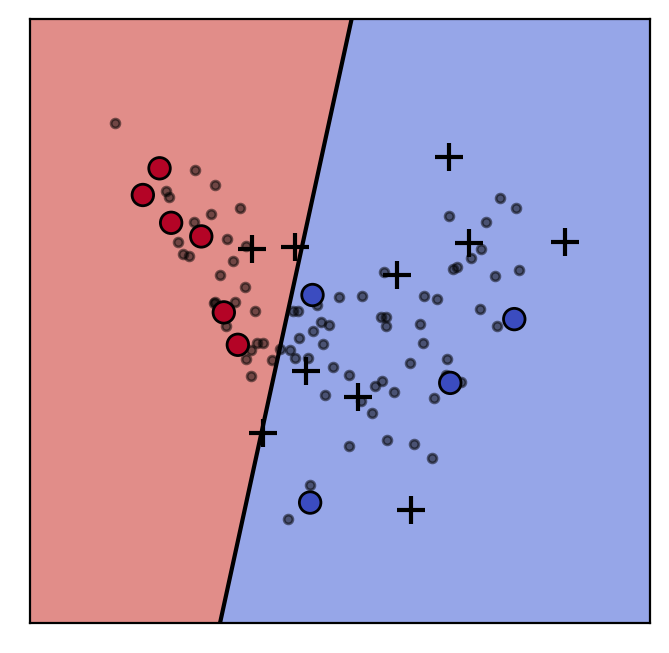

In [205]:
X, y = generateData_twoPills_2D(dataset_size=100)

idx = np.random.choice(X.shape[0], 10, replace=False)

clf = ActiveLearner(estimator=svm.SVC(kernel='linear', probability=True), X_training=X[idx], y_training=y[idx], query_strategy=batch.uncertainty_batch_sampling)
clf_all = svm.SVC(kernel='linear', probability=True)
clf_all.fit(X,y)
print(idx)

mask = np.ones(len(X), bool)
mask[idx] = 0
X_all = X[mask]

fig = plot_classification(None, clf, X[idx], y[idx], X_all, clf_all)

fig.savefig('figures/svm_decision_boundary.png')

## Poison Query Synthesis

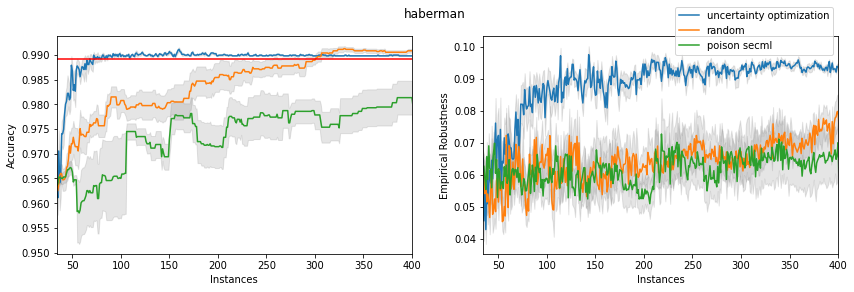

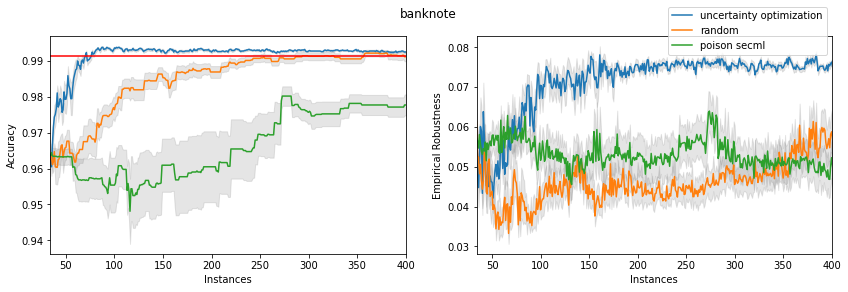

In [17]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

datasets = {
    "haberman": lambda: lru_cache(haberman)(),
    "banknote": lambda: lru_cache(banknote)(),    
    #"car": lambda: lru_cache(car)(),
}

for dataset_name, dataset in tqdm(datasets.items(), desc="Dataset", leave=False):
    X, y = dataset()
    if dataset_name == "car":
        y = LabelEncoder().fit_transform(y)
    X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.025)
    
    solver_params = {
        'eta': 0.3297953991427548,
        'eta_min': None,
        'eta_max': None,
        'max_iter': 100,
        'eps': 0.7261519961245426
    }
    
    query_methods = {
        "uncertainty optimization": partial(uncertainty_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "random": partial(random_synthesis, n_instances=1, bounds=[(np.amin(X[:,i]), np.amax(X[:,i])) for i in range(X.shape[1])]),
        "poison secml": partial(poison_secml, n_instances=1, lb=np.amin(X, axis=0), ub=np.amax(X, axis=0), solver_params=solver_params),
    }
    
    oracle = svm.SVC(kernel='linear')
    oracle.fit(X, y)
    
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}.csv", index_col=0)
        stderr = pd.read_csv(f"Experiments/experiment_synthesis_dataset_{dataset_name}_method_{name}_stderr.csv", index_col=0)
        
        for i, ax in enumerate(axes.flatten()):
            if i == 1:
                i = 3
            if len(metrics['x']) > 100:
                ax.plot(metrics['x'], metrics.iloc[:,1+i], '-', label=f"{name}" if i == 0 else "")
                ax.fill_between(metrics['x'], metrics.iloc[:,1+i]-stderr.iloc[:,1+i], metrics.iloc[:,1+i]+stderr.iloc[:,1+i], color='grey', alpha=0.2)
            else:
                ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC", "Empirical Robustness"][i]); plt.suptitle(f"{dataset_name}")
            ax.set_xlim(34, 400)
    
    axes[0].axhline(accuracy_score(y, oracle.predict(X)), color="red")
    fig.legend(bbox_to_anchor=(0.9,1))
    fig.savefig(f'figures/poison_query_synthesis_{dataset_name}.png')

In [11]:
metrics['x'][0]

34.0